In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
csv_path = './content/MyDrive/drive/data/csv'
artist_train = pd.read_csv('/content/drive/MyDrive/data/csv/Artist/artist_train')
# lets visualize one imag
base_url = '/content/drive/MyDrive/data/images'

In [ ]:
# lets start creating data
artist = '/content/drive/MyDrive/data/csv/Artist'
genre = '/content/drive/MyDrive/data/csv/Genre'
style = '/content/drive/MyDrive/data/csv/Style'
data_dir = '/content/drive/MyDrive/data/csv'

artist_train_path = data_dir + '/artist_train.csv'
artist_val_path = data_dir + '/artist_val.csv'
artist_class_path = data_dir + '/artist_class.txt'

genre_train_path = data_dir + '/genre_train.csv'
genre_val_path = data_dir + '/genre_val.csv'
genre_class_path = data_dir + '/genre_class.txt'

style_train_path = data_dir + '/style_train.csv'
style_val_path = data_dir + '/style_val.csv'
style_class_path = data_dir + '/style_class.txt'

artist_train = pd.read_csv(data_dir + '/artist_train.csv')
artist_val = pd.read_csv(data_dir + '/artist_val.csv')
artist_class = pd.read_csv(artist_class_path, header=None, names=["artist_name"])

genre_train = pd.read_csv(data_dir + '/genre_train.csv')
genre_val = pd.read_csv(data_dir + '/genre_val.csv')
genre_class = pd.read_csv(genre_class_path, header=None, names=["genre_name"])


style_train = pd.read_csv(data_dir + '/style_train.csv')
style_val = pd.read_csv(data_dir + '/style_val.csv')
style_class = pd.read_csv(style_class_path, header=None, names=["style_name"])

# genre_class['genre_name'][1]
len(style_class)

27

Creating balanced artist dataset...
Filtering missing images...
Grouping images by class...


Processing rows: 100%|██████████| 13344/13344 [00:00<00:00, 14836.35it/s]


Balancing dataset...


Processing classes: 100%|██████████| 23/23 [00:00<00:00, 6719.77it/s]


Filling missing slots...
Shuffling dataset...
Filtering missing images...
Grouping images by class...


Processing rows: 100%|██████████| 5706/5706 [00:00<00:00, 22442.96it/s]


Balancing dataset...


Processing classes: 100%|██████████| 23/23 [00:00<00:00, 19878.22it/s]


Filling missing slots...
Shuffling dataset...
Artist balanced dataset size: 4600 1150


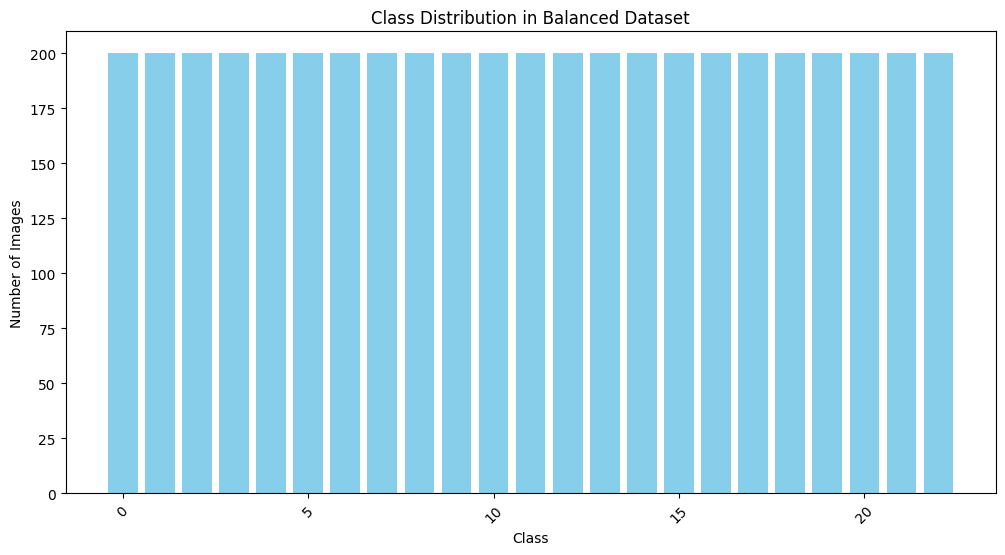

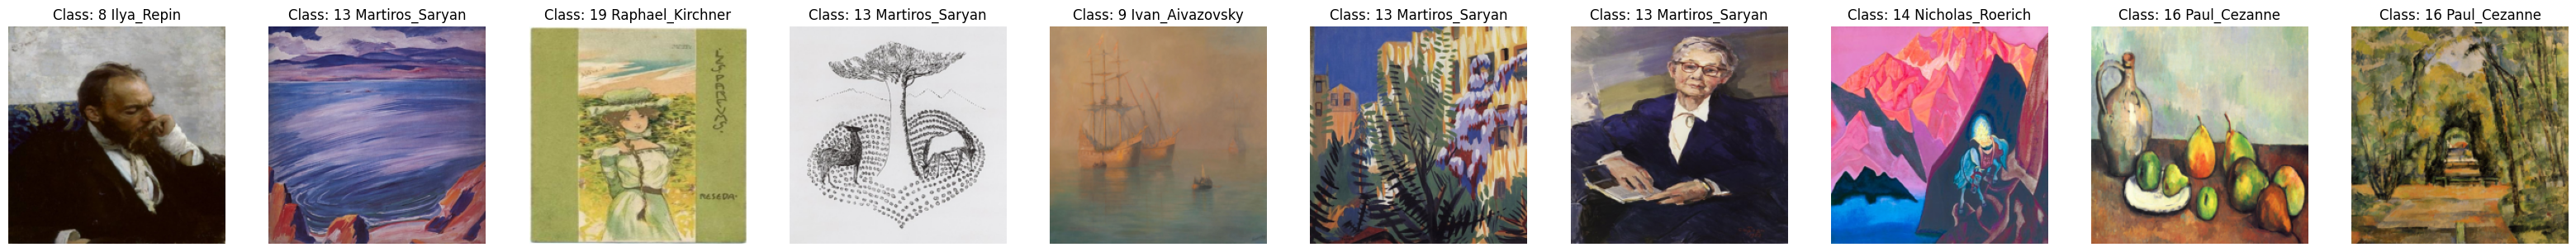

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from collections import defaultdict
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define dataset class
class BalancedArtDataset(Dataset):
    def __init__(self, csv_file, img_dir, class_mapping, transform=None, images_per_class=32):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.class_mapping = class_mapping
        self.transform = transform
        self.images_per_class = images_per_class

        # Filter out missing images
        print("Filtering missing images...")
        self.data = self.data[self.data.iloc[:, 0].apply(lambda x: os.path.exists(os.path.join(img_dir, str(x))))]

        # Group images by class
        print("Grouping images by class...")
        self.class_images = defaultdict(list)
        for _, row in tqdm(self.data.iterrows(), total=len(self.data), desc="Processing rows"):
            self.class_images[row.iloc[1]].append(row)

        # Balance dataset with 32 images per class
        print("Balancing dataset...")
        self.final_data = []
        all_images = []
        for cls, images in tqdm(self.class_images.items(), total=len(self.class_images), desc="Processing classes"):
            if len(images) >= images_per_class:
                selected_images = random.sample(images, images_per_class)
            else:
                selected_images = images[:]
                all_images.extend(images)  # Store extra images for filling
            self.final_data.extend(selected_images)

        # Fill missing slots with extra images
        print("Filling missing slots...")
        needed_images = images_per_class * len(self.class_images) - len(self.final_data)
        if needed_images > 0:
            self.final_data.extend(random.sample(all_images, min(needed_images, len(all_images))))

        # Shuffle dataset
        print("Shuffling dataset...")
        random.shuffle(self.final_data)

        # Count images per class
        self.class_counts = defaultdict(int)
        for row in self.final_data:
            self.class_counts[row.iloc[1]] += 1

    def __len__(self):
        return len(self.final_data)

    def __getitem__(self, idx):
        row = self.final_data[idx]
        img_path = os.path.join(self.img_dir, str(row.iloc[0]))
        label = row.iloc[1]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label, img_path


    def visualize_class_distribution(self):
        plt.figure(figsize=(12, 6))
        plt.bar(self.class_counts.keys(), self.class_counts.values(), color='skyblue')
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.title("Class Distribution in Balanced Dataset")
        plt.xticks(rotation=45)
        plt.show()

    def visualize_samples(self, num_samples=10):
        fig, axes = plt.subplots(1, num_samples, figsize=(40, 20))
        for i in range(num_samples):
            image, label, img_path = self.__getitem__(random.randint(0, len(self) - 1))
            image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
            image = (image * 0.5) + 0.5  # Unnormalize
            axes[i].imshow(image)
            axes[i].set_title(f"Class: {label} {artist_class['artist_name'][label]}")
            axes[i].axis("off")
        plt.show()

    # Function to compare artist and genre relationships



# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create balanced artist dataset
print("Creating balanced artist dataset...")
artist_balanced_dataset = BalancedArtDataset(artist_train_path, "/content/drive/MyDrive/data/images", artist_class_path, transform=transform, images_per_class=200)
artist_test_balanced_dataset = BalancedArtDataset(artist_val_path, "/content/drive/MyDrive/data/images", artist_class_path, transform=transform, images_per_class=50)

# Check dataset length
print("Artist balanced dataset size:", len(artist_balanced_dataset), len(artist_test_balanced_dataset))

# Visualize class distribution
artist_balanced_dataset.visualize_class_distribution()

# Visualize sample images
artist_balanced_dataset.visualize_samples(num_samples=10)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Define DataLoaders
batch_size = 32  # Adjust based on GPU memory

train_loader = DataLoader(artist_balanced_dataset, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)
val_loader = DataLoader(artist_test_balanced_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("Dataloaders created successfully!")


Dataloaders created successfully!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Hyperparameters
num_epochs_fc = 5  # Train FC layer only for 5 epochs
num_epochs_finetune = 6  # Fine-tune entire model for 10 more epochs
initial_lr = 0.001  # Learning rate for training FC layer
finetune_lr = 1e-4  # Lower learning rate for fine-tuning
batch_size = 32
weight_decay = 1e-4  # L2 regularization


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
# Load pre-trained ResNet-18 model
# Load pre-trained ResNet-18 model
num_classes = len(artist_class)  # Number of output classes
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)  # Replace final FC layer
model = model.to(device)

# Define loss function and optimizer for FC layer training
criterion = nn.CrossEntropyLoss()
fc_optimizer = optim.Adam(model.fc.parameters(), lr=initial_lr, weight_decay=weight_decay)

# Function to train the FC layer only
def train_fc_layer():
    print("Starting Step 1: Training FC Layer Only...")

    # Freeze all layers except the FC layer
    for param in model.parameters():
        param.requires_grad = False  # Freeze all pretrained layers

    # Ensure the new FC layer has requires_grad=True
    for param in model.fc.parameters():
        param.requires_grad = True

    model.train()  # Set the model to training mode

    for epoch in range(num_epochs_fc):
        running_loss, correct, total = 0.0, 0, 0

        loop = tqdm(train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs_fc}]")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            fc_optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass to compute gradients
            fc_optimizer.step()  # Update FC layer weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        print(f"Epoch [{epoch+1}/{num_epochs_fc}], Loss: {running_loss / len(train_loader):.4f}, "
              f"Accuracy: {100 * correct / total:.2f}%")

    print("🎯 Step 1 Complete: FC Layer Training Finished!")

# Step 2: Fine-Tuning Entire Network
def fine_tune():
    print("Starting Step 2: Fine-Tuning the Entire Network...")
    for param in model.parameters():
        param.requires_grad = True  # Unfreeze all layers

    # Define optimizer and scheduler for fine-tuning
    finetune_optimizer = optim.Adam(model.parameters(), lr=finetune_lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(finetune_optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    best_val_loss = float('inf')

    for epoch in range(num_epochs_finetune):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs_finetune}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            finetune_optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            finetune_optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        # Validation phase
        val_loss, val_acc = evaluate(val_loader)
        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs_finetune}], "
              f"Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {100 * correct / total:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "/content/drive/MyDrive/art_model/best_resnet18_model_200.pth")
            print("✅ Best model saved!")

    print("🎯 Step 2 Complete: Fine-Tuning Finished!")

# Function to evaluate the model on validation data
def evaluate(loader):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = val_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# Start Training: Step 1 (Train FC Layer) and Step 2 (Fine-Tuning)
train_fc_layer()  # Train the FC layer only
fine_tune()       # Fine-tune the entire ResNet model

print("🎉 Training complete! The best model is saved as 'best_resnet18_model.pth'.")

Starting Step 1: Training FC Layer Only...


Epoch [1/5]: 100%|██████████| 144/144 [04:22<00:00,  1.83s/it, acc=34.1, loss=2.38]


Epoch [1/5], Loss: 2.3813, Accuracy: 34.09%


Epoch [2/5]: 100%|██████████| 144/144 [01:17<00:00,  1.86it/s, acc=54.7, loss=1.64]


Epoch [2/5], Loss: 1.6399, Accuracy: 54.67%


Epoch [3/5]: 100%|██████████| 144/144 [01:15<00:00,  1.90it/s, acc=60.5, loss=1.4]


Epoch [3/5], Loss: 1.3960, Accuracy: 60.50%


Epoch [4/5]: 100%|██████████| 144/144 [01:17<00:00,  1.87it/s, acc=64.5, loss=1.25]


Epoch [4/5], Loss: 1.2537, Accuracy: 64.48%


Epoch [5/5]: 100%|██████████| 144/144 [01:15<00:00,  1.91it/s, acc=66.5, loss=1.16]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [5/5], Loss: 1.1638, Accuracy: 66.46%
🎯 Step 1 Complete: FC Layer Training Finished!
Starting Step 2: Fine-Tuning the Entire Network...


Epoch [1/6]: 100%|██████████| 144/144 [01:19<00:00,  1.81it/s, acc=71, loss=0.98]


Epoch [1/6], Train Loss: 0.9796, Train Acc: 71.00%, Val Loss: 0.9080, Val Acc: 73.13%
✅ Best model saved!


Epoch [2/6]: 100%|██████████| 144/144 [01:20<00:00,  1.80it/s, acc=96.9, loss=0.188]


Epoch [2/6], Train Loss: 0.1881, Train Acc: 96.93%, Val Loss: 0.8028, Val Acc: 76.26%
✅ Best model saved!


Epoch [3/6]: 100%|██████████| 144/144 [01:19<00:00,  1.80it/s, acc=99.8, loss=0.0509]


Epoch [3/6], Train Loss: 0.0509, Train Acc: 99.83%, Val Loss: 0.7850, Val Acc: 77.30%
✅ Best model saved!


Epoch [4/6]: 100%|██████████| 144/144 [01:20<00:00,  1.79it/s, acc=100, loss=0.0227]


Epoch [4/6], Train Loss: 0.0227, Train Acc: 100.00%, Val Loss: 0.7812, Val Acc: 78.17%
✅ Best model saved!


Epoch [5/6]: 100%|██████████| 144/144 [01:19<00:00,  1.81it/s, acc=100, loss=0.0137]


Epoch [5/6], Train Loss: 0.0137, Train Acc: 100.00%, Val Loss: 0.7947, Val Acc: 77.65%


Epoch [6/6]: 100%|██████████| 144/144 [01:19<00:00,  1.82it/s, acc=100, loss=0.00997]


Epoch [6/6], Train Loss: 0.0100, Train Acc: 100.00%, Val Loss: 0.7785, Val Acc: 78.52%
✅ Best model saved!
🎯 Step 2 Complete: Fine-Tuning Finished!
🎉 Training complete! The best model is saved as 'best_resnet18_model.pth'.


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/art_model/best_resnet18_model_200.pth", map_location=device))
model = model.to(device)

# Set the model to evaluation mode for inference
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch

# Load the entire model, explicitly setting `weights_only=False`
loaded_model = torch.load('/content/drive/MyDrive/art_model/artist_model_02_resnet_18.pth', weights_only=False)
loaded_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

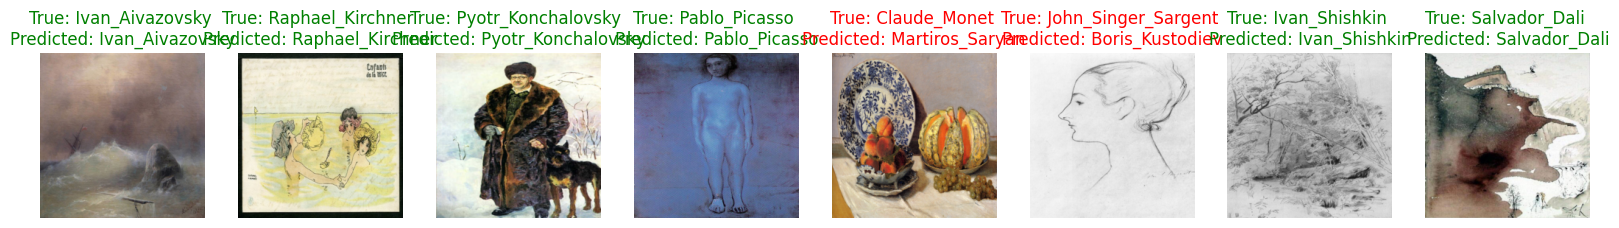

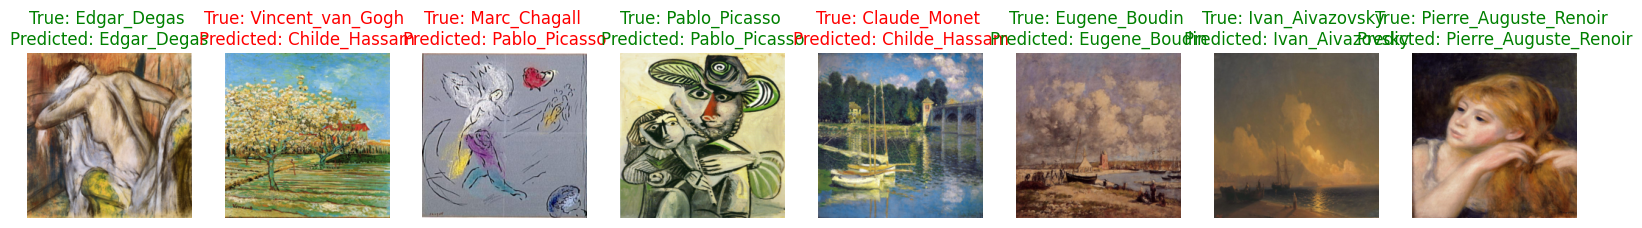

In [ ]:
import torch
import matplotlib.pyplot as plt
import random
random.seed(42)

# Function to visualize random predictions from test dataset
def visualize_random_predictions(model, dataset, class_mapping, num_samples=8):
    model.eval()  # Set model to evaluation mode
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 8))

    with torch.no_grad():  # Disable gradient calculation for inference
        for i in range(num_samples):
            # Pick a random index from the dataset
            idx = random.randint(0, len(dataset) - 1)
            image, true_label = dataset[idx]

            # Add batch dimension and move image to the appropriate device
            image_batch = image.unsqueeze(0).to(device)

            # Make a prediction
            output = model(image_batch)
            _, predicted_label = torch.max(output, 1)

            # Convert image tensor to numpy and unnormalize
            image = image.permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) -> (H, W, C)
            image = (image * 0.5) + 0.5  # Unnormalize image

            # Display the image and predictions
            axes[i].imshow(image)
            axes[i].set_title(
                f"True: {class_mapping['artist_name'][true_label]} \nPredicted: {class_mapping['artist_name'][predicted_label.item()]}",
                color=("green" if true_label == predicted_label.item() else "red"),
                fontsize=12,
            )
            axes[i].axis("off")

    plt.show()


# Visualize random predictions on test dataset (Adjust `num_samples` as needed)
visualize_random_predictions(model, artist_test_balanced_dataset, artist_class, num_samples=8)
# Visualize random predictions on test dataset (Adjust `num_samples` as needed)
visualize_random_predictions(loaded_model, artist_test_balanced_dataset, artist_class, num_samples=8)


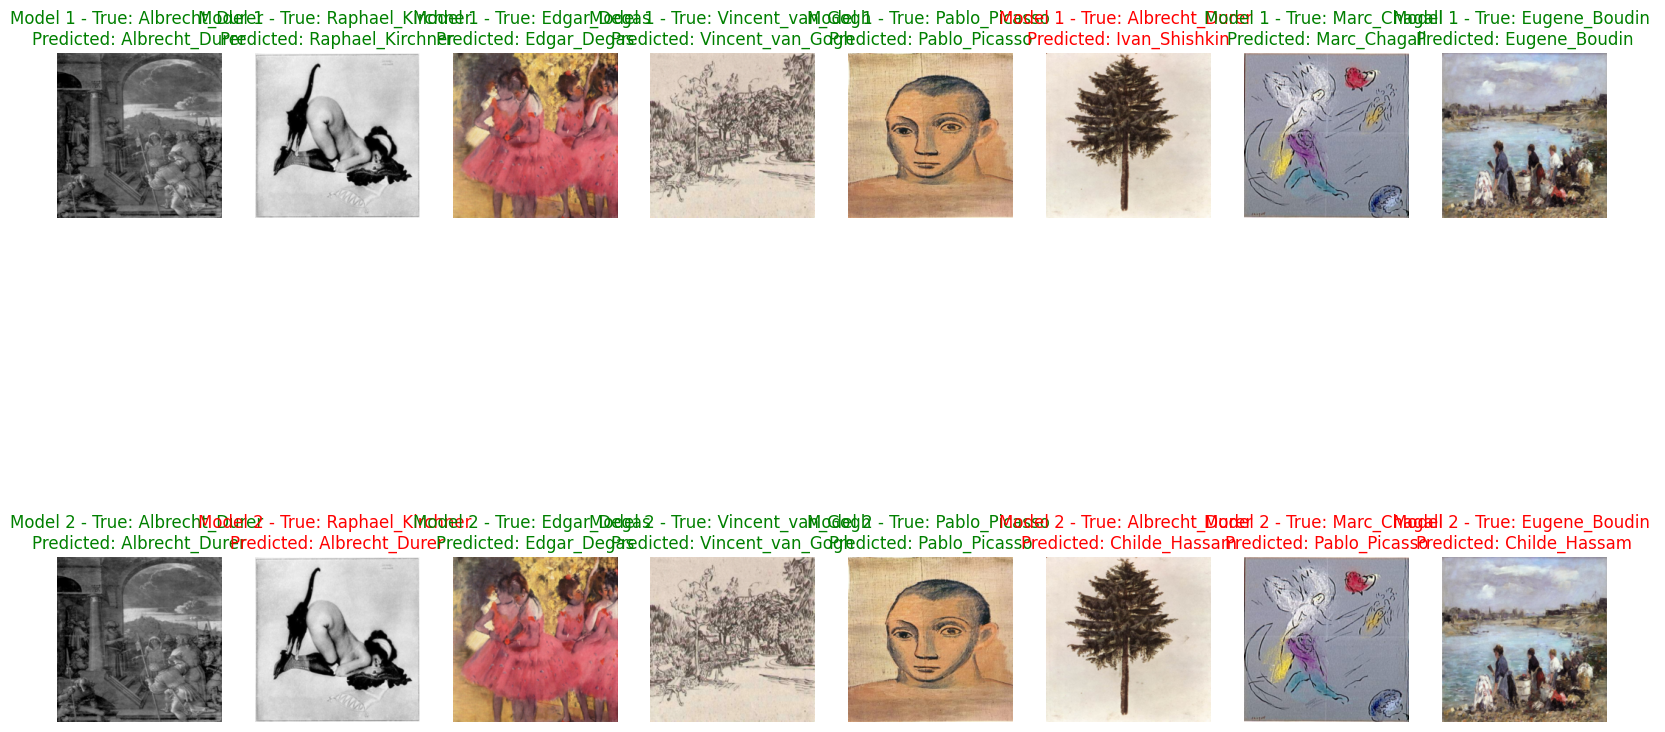

In [ ]:
import torch
import matplotlib.pyplot as plt
import random


# Function to visualize random predictions from test dataset on the same images for both models
def visualize_same_random_predictions(model1, model2, dataset, class_mapping, num_samples=8):
    model1.eval()  # Set models to evaluation mode
    model2.eval()

    fig, axes = plt.subplots(2, num_samples, figsize=(20, 12))  # Two rows: one for each model

    # Generate fixed random indices to ensure both models predict on the same images
    fixed_indices = [random.randint(0, len(dataset) - 1) for _ in range(num_samples)]

    with torch.no_grad():  # Disable gradient calculation for inference
        for i, idx in enumerate(fixed_indices):
            image, true_label = dataset[idx]

            # Add batch dimension and move image to the appropriate device
            image_batch = image.unsqueeze(0).to(device)

            # Make predictions with both models
            output1 = model1(image_batch)
            output2 = model2(image_batch)
            _, predicted_label1 = torch.max(output1, 1)
            _, predicted_label2 = torch.max(output2, 1)

            # Convert image tensor to numpy and unnormalize
            image = image.permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) -> (H, W, C)
            image = (image * 0.5) + 0.5  # Unnormalize image

            # Display the image and predictions for model1 (top row)
            axes[0, i].imshow(image)
            axes[0, i].set_title(
                f"Model 1 - True: {class_mapping['artist_name'][true_label]} \nPredicted: {class_mapping['artist_name'][predicted_label1.item()]}",
                color=("green" if true_label == predicted_label1.item() else "red"),
                fontsize=12,
            )
            axes[0, i].axis("off")

            # Display the image and predictions for model2 (bottom row)
            axes[1, i].imshow(image)
            axes[1, i].set_title(
                f"Model 2 - True: {class_mapping['artist_name'][true_label]} \nPredicted: {class_mapping['artist_name'][predicted_label2.item()]}",
                color=("green" if true_label == predicted_label2.item() else "red"),
                fontsize=12,
            )
            axes[1, i].axis("off")

    plt.show()


# Visualize random predictions on test dataset for both models on the same set of images
visualize_same_random_predictions(model, loaded_model, artist_test_balanced_dataset, artist_class, num_samples=8)


Original Image Path: /content/drive/MyDrive/data/images/Art_Nouveau_Modern/raphael-kirchner_roma-6.jpg
Relative Path: Art_Nouveau_Modern/raphael-kirchner_roma-6.jpg
Original Image Path: /content/drive/MyDrive/data/images/Synthetic_Cubism/pablo-picasso_guitar.jpg
Relative Path: Synthetic_Cubism/pablo-picasso_guitar.jpg
Original Image Path: /content/drive/MyDrive/data/images/Baroque/rembrandt_charitable-samaritan-also-known-as-the-good-samaritan-1638.jpg
Relative Path: Baroque/rembrandt_charitable-samaritan-also-known-as-the-good-samaritan-1638.jpg
Original Image Path: /content/drive/MyDrive/data/images/Romanticism/gustave-dore_the-inferno-canto-31.jpg
Relative Path: Romanticism/gustave-dore_the-inferno-canto-31.jpg
Original Image Path: /content/drive/MyDrive/data/images/Naive_Art_Primitivism/pablo-picasso_nude-with-picasso-by-her-feet.jpg
Relative Path: Naive_Art_Primitivism/pablo-picasso_nude-with-picasso-by-her-feet.jpg
Original Image Path: /content/drive/MyDrive/data/images/Symbolism

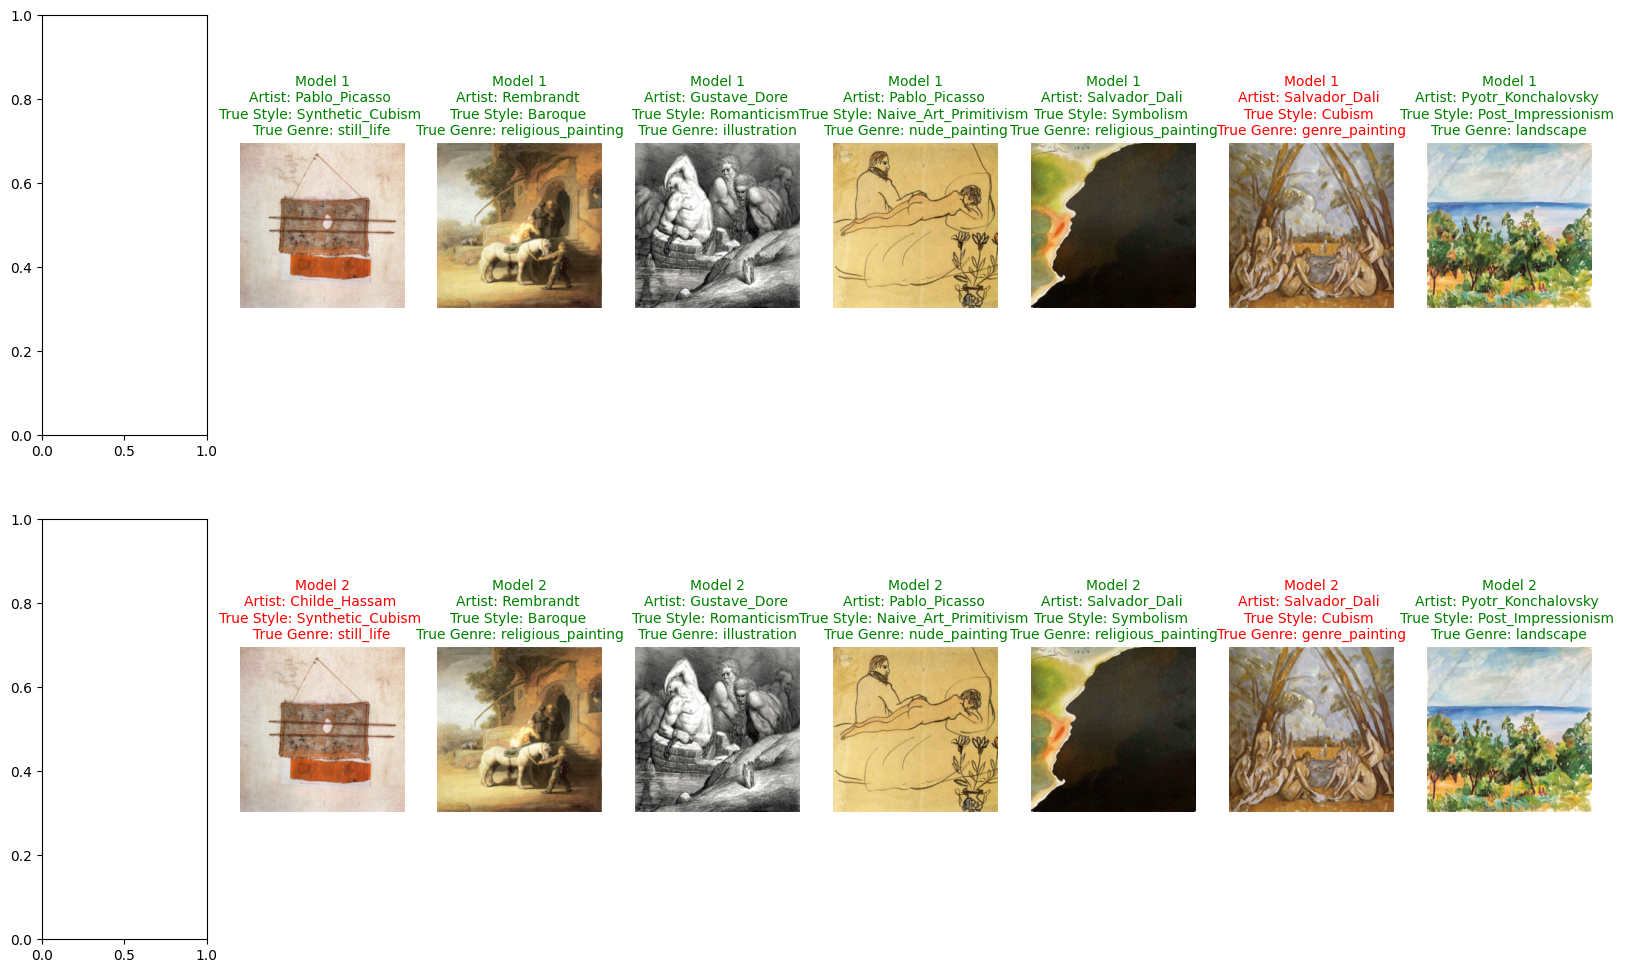

In [ ]:
import torch
import matplotlib.pyplot as plt
import random

# Function to visualize random predictions with true artist, style, and genre classes
def visualize_predictions_with_true_classes(model1, model2, dataset, artist_class, style_class, genre_class, style_val, genre_val, num_samples=8):
    model1.eval()  # Set models to evaluation mode
    model2.eval()

    # Normalize paths in style_val and genre_val
    style_val2 = {
        path.strip().replace("\\", "/"): class_no
        for path, class_no in zip(style_val['path'], style_val['class_no'])
    }
    genre_val2 = {
        path.strip().replace("\\", "/"): class_no
        for path, class_no in zip(genre_val['path'], genre_val['class_no'])
    }

    fig, axes = plt.subplots(2, num_samples, figsize=(20, 12))  # Two rows: one for each model

    # Generate fixed random indices to ensure both models predict on the same images
    fixed_indices = [random.randint(0, len(dataset) - 1) for _ in range(num_samples)]

    with torch.no_grad():  # Disable gradient calculation for inference
        for i, idx in enumerate(fixed_indices):
            # Unpack image, true artist label, and image path
            image, true_artist_label, image_path = dataset[idx]

            print(f"Original Image Path: {image_path}")  # Debugging line

            # Modify the image path to extract the relative path after "images/"
            relative_path = image_path.split("images/")[-1]  # Extract relative path
            relative_path = relative_path.strip().replace("\\", "/")  # Normalize path

            print(f"Relative Path: {relative_path}")  # Debugging line

            # Check if the relative path exists in the mappings, and handle missing cases
            if relative_path in style_val2 and relative_path in genre_val2:
                true_style_label = style_val2[relative_path]  # Use the normalized dictionary
                true_genre_label = genre_val2[relative_path]  # Use the normalized dictionary
            else:
                print(f"Warning: Relative path {relative_path} not found in style_val or genre_val.")
                continue  # Skip the sample if not found in the mappings

            # Add batch dimension and move image to the appropriate device
            image_batch = image.unsqueeze(0).to(device)

            # Make predictions with both models
            output1 = model1(image_batch)
            output2 = model2(image_batch)

            # Get predicted artist labels for both models
            _, predicted_artist1 = torch.max(output1, 1)
            _, predicted_artist2 = torch.max(output2, 1)

            # Convert image tensor to numpy and unnormalize
            image = image.permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) -> (H, W, C)
            image = (image * 0.5) + 0.5  # Unnormalize image

            # Display the image and predictions for model1 (top row)
            axes[0, i].imshow(image)
            axes[0, i].set_title(
                f"Model 1\nArtist: {artist_class['artist_name'][predicted_artist1.item()]} \n"
                f"True Style: {style_class['style_name'][true_style_label]} \n"
                f"True Genre: {genre_class['genre_name'][true_genre_label]}",
                color=("green" if true_artist_label == predicted_artist1.item() else "red"),
                fontsize=10,
            )
            axes[0, i].axis("off")

            # Display the image and predictions for model2 (bottom row)
            axes[1, i].imshow(image)
            axes[1, i].set_title(
                f"Model 2\nArtist: {artist_class['artist_name'][predicted_artist2.item()]} \n"
                f"True Style: {style_class['style_name'][true_style_label]} \n"
                f"True Genre: {genre_class['genre_name'][true_genre_label]}",
                color=("green" if true_artist_label == predicted_artist2.item() else "red"),
                fontsize=10,
            )
            axes[1, i].axis("off")

    plt.show()

# Example usage of the function (assuming `style_val` and `genre_val` are defined mappings)
visualize_predictions_with_true_classes(
    model,
    loaded_model,
    artist_test_balanced_dataset,
    artist_class,
    style_class,
    genre_class,
    style_val,  # Dictionary mapping relative image paths to style class indices
    genre_val,  # Dictionary mapping relative image paths to genre class indices
    num_samples=8
)


In [ ]:
# Load your DataFrame (replace this with the path to your actual CSV)
# style_val_df = pd.read_csv('style_values.csv')

# Convert DataFrame to dictionary with normalized paths
style_val2 = {
    path.strip().replace("\\", "/"): class_no
    for path, class_no in zip(style_val['path'], style_val['class_no'])
}
key = 'Impressionism/edgar-degas_dancers-on-set-1880.jpg'  # Your specific path
key = key.strip().replace("\\", "/")  # Normalize the path to match dictionary keys

if key in style_val2:
    print("Found! Class number:", style_val2[key])
else:
    print(f"Key '{key}' not found in style_val2.")


Found! Class number: 12


In [ ]:
style_val

path  class_no
0      Impressionism/edgar-degas_dancers-on-set-1880.jpg        12
1          Impressionism/claude-monet_water-lilies-6.jpg        12
2      Impressionism/giovanni-boldini_a-guitar-player...        12
3      Impressionism/john-singer-sargent_at-torre-gal...        12
4      Impressionism/john-singer-sargent_artist-in-th...        12
...                                                  ...       ...
24416  Naive_Art_Primitivism/niko-pirosmani_leaning-a...        15
24417  Naive_Art_Primitivism/marc-chagall_russian-wed...        15
24418  Naive_Art_Primitivism/camille-bombois_port-de-...        15
24419  Naive_Art_Primitivism/marc-chagall_god-directs...        15
24420  Naive_Art_Primitivism/natalia-goncharova_sheep...        15

[24421 rows x 2 columns]

## Style datast

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from collections import defaultdict
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define dataset class
class BalancedArtDataset(Dataset):
    def __init__(self, csv_file, img_dir, class_mapping, return_path = False, transform=None, images_per_class=32):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.class_mapping = class_mapping
        self.transform = transform
        self.images_per_class = images_per_class
        self.return_path = return_path  # Ensure this is set as an attribute


        # Filter out missing images
        print("Filtering missing images...")
        self.data = self.data[self.data.iloc[:, 0].apply(lambda x: os.path.exists(os.path.join(img_dir, str(x))))]

        # Group images by class
        print("Grouping images by class...")
        self.class_images = defaultdict(list)
        for _, row in tqdm(self.data.iterrows(), total=len(self.data), desc="Processing rows"):
            self.class_images[row.iloc[1]].append(row)

        # Balance dataset with 32 images per class
        print("Balancing dataset...")
        self.final_data = []
        all_images = []
        for cls, images in tqdm(self.class_images.items(), total=len(self.class_images), desc="Processing classes"):
            if len(images) >= images_per_class:
                selected_images = random.sample(images, images_per_class)
            else:
                selected_images = images[:]
                all_images.extend(images)  # Store extra images for filling
            self.final_data.extend(selected_images)

        # Fill missing slots with extra images
        print("Filling missing slots...")
        needed_images = images_per_class * len(self.class_images) - len(self.final_data)
        if needed_images > 0:
            self.final_data.extend(random.sample(all_images, min(needed_images, len(all_images))))

        # Shuffle dataset
        print("Shuffling dataset...")
        random.shuffle(self.final_data)

        # Count images per class
        self.class_counts = defaultdict(int)
        for row in self.final_data:
            self.class_counts[row.iloc[1]] += 1

    def __len__(self):
        return len(self.final_data)

    def __getitem__(self, idx):
        row = self.final_data[idx]
        img_path = os.path.join(self.img_dir, str(row.iloc[0]))
        label = row.iloc[1]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.return_path:  # Return img_path if flag is set
            return image, label, img_path
        else:  # Return only image and label for model training
            return image, label



    def visualize_class_distribution(self):
        plt.figure(figsize=(12, 6))
        plt.bar(self.class_counts.keys(), self.class_counts.values(), color='skyblue')
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.title("Class Distribution in Balanced Dataset")
        plt.xticks(rotation=45)
        plt.show()

    def visualize_samples(self, num_samples=10):
        fig, axes = plt.subplots(1, num_samples, figsize=(40, 20))
        for i in range(num_samples):
            image, label, img_path = self.__getitem__(random.randint(0, len(self) - 1))
            image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
            image = (image * 0.5) + 0.5  # Unnormalize
            axes[i].imshow(image)
            axes[i].set_title(f"Class: {label} {artist_class['artist_name'][label]}")
            axes[i].axis("off")
        plt.show()

    # Function to compare artist and genre relationships



# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



In [ ]:
style_balanced_dataset = BalancedArtDataset(style_train_path, "/content/drive/MyDrive/data/images", style_class_path, transform=transform, return_path=False, images_per_class=200)
style_test_balanced_dataset = BalancedArtDataset(style_val_path, "/content/drive/MyDrive/data/images", style_class_path, transform=transform,return_path=False, images_per_class=50)
len(style_balanced_dataset)

Filtering missing images...
Grouping images by class...


Processing rows: 100%|██████████| 55610/55610 [00:03<00:00, 17632.04it/s]


Balancing dataset...


Processing classes: 100%|██████████| 27/27 [00:00<00:00, 12056.45it/s]


Filling missing slots...
Shuffling dataset...
Filtering missing images...
Grouping images by class...


Processing rows: 100%|██████████| 23818/23818 [00:01<00:00, 12965.21it/s]


Balancing dataset...


Processing classes: 100%|██████████| 27/27 [00:00<00:00, 13497.76it/s]

Filling missing slots...
Shuffling dataset...


5296

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Define DataLoaders
batch_size = 32  # Adjust based on GPU memory

style_train_loader = DataLoader(style_balanced_dataset, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)
style_val_loader = DataLoader(style_test_balanced_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("Dataloaders created successfully!")

# Hyperparameters
num_epochs_fc = 5  # Train FC layer only for 5 epochs
num_epochs_finetune = 5  # Fine-tune entire model for 10 more epochs
initial_lr = 0.001  # Learning rate for training FC layer
finetune_lr = 1e-4  # Lower learning rate for fine-tuning
batch_size = 32
weight_decay = 1e-4  # L2 regularization


Dataloaders created successfully!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
# Load pre-trained ResNet-18 model
# Load pre-trained ResNet-18 model
num_classes = len(style_class)  # Number of output classes
model_style = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_style.fc = nn.Linear(model_style.fc.in_features, num_classes).to(device)  # Replace final FC layer
model_style = model_style.to(device)

# Define loss function and optimizer for FC layer training
criterion = nn.CrossEntropyLoss()
fc_optimizer = optim.Adam(model_style.fc.parameters(), lr=initial_lr, weight_decay=weight_decay)

# Function to train the FC layer only
def train_fc_layer():
    print("Starting Step 1: Training FC Layer Only...")

    # Freeze all layers except the FC layer
    for param in model_style.parameters():
        param.requires_grad = False  # Freeze all pretrained layers

    # Ensure the new FC layer has requires_grad=True
    for param in model_style.fc.parameters():
        param.requires_grad = True

    model_style.train()  # Set the model to training mode

    for epoch in range(num_epochs_fc):
        running_loss, correct, total = 0.0, 0, 0

        loop = tqdm(style_train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs_fc}]")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            fc_optimizer.zero_grad()  # Zero the gradients
            outputs = model_style(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass to compute gradients
            fc_optimizer.step()  # Update FC layer weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss / len(style_train_loader), acc=100 * correct / total)

        print(f"Epoch [{epoch+1}/{num_epochs_fc}], Loss: {running_loss / len(style_train_loader):.4f}, "
              f"Accuracy: {100 * correct / total:.2f}%")

    print("🎯 Step 1 Complete: FC Layer Training Finished!")

# Step 2: Fine-Tuning Entire Network
def fine_tune():
    print("Starting Step 2: Fine-Tuning the Entire Network...")
    for param in model_style.parameters():
        param.requires_grad = True  # Unfreeze all layers

    # Define optimizer and scheduler for fine-tuning
    finetune_optimizer = optim.Adam(model_style.parameters(), lr=finetune_lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(finetune_optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    best_val_loss = float('inf')

    for epoch in range(num_epochs_finetune):
        model_style.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(style_train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs_finetune}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            finetune_optimizer.zero_grad()
            outputs = model_style(images)
            loss = criterion(outputs, labels)
            loss.backward()
            finetune_optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss / len(style_train_loader), acc=100 * correct / total)

        # Validation phase
        val_loss, val_acc = evaluate(style_val_loader)
        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs_finetune}], "
              f"Train Loss: {running_loss / len(style_train_loader):.4f}, Train Acc: {100 * correct / total:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model_style.state_dict(), "/content/drive/MyDrive/art_model/best_resnet18_style_model_200.pth")
            print("✅ Best model saved!")

    print("🎯 Step 2 Complete: Fine-Tuning Finished!")

# Function to evaluate the model on validation data
def evaluate(loader):
    model_style.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels ,  = images.to(device), labels.to(device)
            outputs = model_style(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = val_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# Start Training: Step 1 (Train FC Layer) and Step 2 (Fine-Tuning)
train_fc_layer()  # Train the FC layer only
fine_tune()       # Fine-tune the entire ResNet model

print("🎉 Training complete! The best model is saved as 'best_resnet18_model.pth'.")

Starting Step 1: Training FC Layer Only...


Epoch [1/5]:  14%|█▍        | 23/166 [00:25<02:20,  1.02it/s, acc=6.51, loss=0.483]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch [1/5]: 100%|██████████| 166/166 [01:48<00:00,  1.53it/s, acc=23.5, loss=2.69]


Epoch [1/5], Loss: 2.6946, Accuracy: 23.51%


Epoch [2/5]:  64%|██████▍   | 107/166 [01:03<00:24,  2.39it/s, acc=40.4, loss=1.32]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch [2/5]: 100%|██████████| 166/166 [01:36<00:00,  1.72it/s, acc=41.5, loss=2.02]


Epoch [2/5], Loss: 2.0170, Accuracy: 41.47%


Epoch [3/5]:   8%|▊         | 14/166 [00:11<01:34,  1.61it/s, acc=47.5, loss=0.175]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch [3/5]: 100%|██████████| 166/166 [01:34<00:00,  1.75it/s, acc=46.9, loss=1.81]


Epoch [3/5], Loss: 1.8091, Accuracy: 46.90%


Epoch [4/5]:  56%|█████▌    | 93/166 [00:57<00:29,  2.47it/s, acc=50, loss=0.935]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch [4/5]: 100%|██████████| 166/166 [01:38<00:00,  1.69it/s, acc=49.7, loss=1.68]


Epoch [4/5], Loss: 1.6815, Accuracy: 49.66%


Epoch [5/5]:  51%|█████     | 84/166 [00:49<00:33,  2.44it/s, acc=52.5, loss=0.802]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch [5/5]: 100%|██████████| 166/166 [01:41<00:00,  1.63it/s, acc=51.5, loss=1.6]


Epoch [5/5], Loss: 1.6000, Accuracy: 51.53%
🎯 Step 1 Complete: FC Layer Training Finished!
Starting Step 2: Fine-Tuning the Entire Network...


Epoch [1/5]:   0%|          | 0/166 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch [1/5]: 100%|██████████| 166/166 [02:05<00:00,  1.33it/s, acc=54.1, loss=1.47]


Epoch [1/5], Train Loss: 1.4744, Train Acc: 54.12%, Val Loss: 1.6001, Val Acc: 50.15%
✅ Best model saved!


Epoch [2/5]:  14%|█▍        | 24/166 [00:17<01:35,  1.49it/s, acc=86.5, loss=0.0888]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch [2/5]: 100%|██████████| 166/166 [01:44<00:00,  1.59it/s, acc=86.9, loss=0.556]


Epoch [2/5], Train Loss: 0.5557, Train Acc: 86.88%, Val Loss: 1.5541, Val Acc: 52.52%
✅ Best model saved!


Epoch [3/5]:  88%|████████▊ | 146/166 [01:31<00:11,  1.67it/s, acc=98, loss=0.171]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch [3/5]: 100%|██████████| 166/166 [01:41<00:00,  1.64it/s, acc=97.9, loss=0.194]


Epoch [3/5], Train Loss: 0.1942, Train Acc: 97.92%, Val Loss: 1.5494, Val Acc: 52.67%
✅ Best model saved!


Epoch [4/5]:  10%|▉         | 16/166 [00:13<01:18,  1.91it/s, acc=99.2, loss=0.00788]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch [4/5]: 100%|██████████| 166/166 [01:39<00:00,  1.67it/s, acc=99.6, loss=0.075]


Epoch [4/5], Train Loss: 0.0750, Train Acc: 99.57%, Val Loss: 1.5867, Val Acc: 53.26%


Epoch [5/5]:  64%|██████▍   | 106/166 [01:04<00:28,  2.07it/s, acc=99.7, loss=0.0277]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch [5/5]: 100%|██████████| 166/166 [01:41<00:00,  1.64it/s, acc=99.7, loss=0.0415]


Epoch [5/5], Train Loss: 0.0415, Train Acc: 99.72%, Val Loss: 1.6110, Val Acc: 53.78%
🎯 Step 2 Complete: Fine-Tuning Finished!
🎉 Training complete! The best model is saved as 'best_resnet18_model.pth'.


## Genre dataset

In [ ]:
genre_balanced_dataset = BalancedArtDataset(genre_train_path, "/content/drive/MyDrive/data/images", genre_class_path, transform=transform, return_path=False, images_per_class=450)
genre_test_balanced_dataset = BalancedArtDataset(genre_val_path, "/content/drive/MyDrive/data/images", genre_class_path, transform=transform,return_path=False, images_per_class=100)
len(genre_balanced_dataset)

Filtering missing images...
Grouping images by class...


Processing rows: 100%|██████████| 44393/44393 [00:02<00:00, 16196.42it/s]


Balancing dataset...


Processing classes: 100%|██████████| 10/10 [00:00<00:00, 1698.37it/s]


Filling missing slots...
Shuffling dataset...
Filtering missing images...
Grouping images by class...


Processing rows: 100%|██████████| 19005/19005 [00:01<00:00, 16650.14it/s]


Balancing dataset...


Processing classes: 100%|██████████| 10/10 [00:00<00:00, 9754.20it/s]

Filling missing slots...
Shuffling dataset...


4500

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Define DataLoaders
batch_size = 32  # Adjust based on GPU memory

genre_train_loader = DataLoader(genre_balanced_dataset, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)
gnere_val_loader = DataLoader(genre_test_balanced_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("Dataloaders created successfully!")

# Hyperparameters
num_epochs_fc = 5  # Train FC layer only for 5 epochs
num_epochs_finetune = 5  # Fine-tune entire model for 10 more epochs
initial_lr = 0.001  # Learning rate for training FC layer
finetune_lr = 1e-4  # Lower learning rate for fine-tuning
batch_size = 32
weight_decay = 1e-4  # L2 regularization


Dataloaders created successfully!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
# Load pre-trained ResNet-18 model
# Load pre-trained ResNet-18 model
num_classes = len(genre_class)  # Number of output classes
model_genre = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_genre.fc = nn.Linear(model_genre.fc.in_features, num_classes).to(device)  # Replace final FC layer
model_genre = model_genre.to(device)

# Define loss function and optimizer for FC layer training
criterion = nn.CrossEntropyLoss()
fc_optimizer = optim.Adam(model_genre.fc.parameters(), lr=initial_lr, weight_decay=weight_decay)

# Function to train the FC layer only
def train_fc_layer():
    print("Starting Step 1: Training FC Layer Only...")

    # Freeze all layers except the FC layer
    for param in model_genre.parameters():
        param.requires_grad = False  # Freeze all pretrained layers

    # Ensure the new FC layer has requires_grad=True
    for param in model_genre.fc.parameters():
        param.requires_grad = True

    model_genre.train()  # Set the model to training mode

    for epoch in range(num_epochs_fc):
        running_loss, correct, total = 0.0, 0, 0

        loop = tqdm(genre_train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs_fc}]")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            fc_optimizer.zero_grad()  # Zero the gradients
            outputs = model_genre(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass to compute gradients
            fc_optimizer.step()  # Update FC layer weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss / len(genre_train_loader), acc=100 * correct / total)

        print(f"Epoch [{epoch+1}/{num_epochs_fc}], Loss: {running_loss / len(genre_train_loader):.4f}, "
              f"Accuracy: {100 * correct / total:.2f}%")

    print("🎯 Step 1 Complete: FC Layer Training Finished!")

# Step 2: Fine-Tuning Entire Network
def fine_tune():
    print("Starting Step 2: Fine-Tuning the Entire Network...")
    for param in model_genre.parameters():
        param.requires_grad = True  # Unfreeze all layers

    # Define optimizer and scheduler for fine-tuning
    finetune_optimizer = optim.Adam(model_genre.parameters(), lr=finetune_lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(finetune_optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    best_val_loss = float('inf')

    for epoch in range(num_epochs_finetune):
        model_genre.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(genre_train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs_finetune}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            finetune_optimizer.zero_grad()
            outputs = model_genre(images)
            loss = criterion(outputs, labels)
            loss.backward()
            finetune_optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss / len(genre_train_loader), acc=100 * correct / total)

        # Validation phase
        val_loss, val_acc = evaluate(gnere_val_loader)
        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs_finetune}], "
              f"Train Loss: {running_loss / len(genre_train_loader):.4f}, Train Acc: {100 * correct / total:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model_genre.state_dict(), "/content/drive/MyDrive/art_model/best_resnet18_genre_model_450.pth")
            print("✅ Best model saved!")

    print("🎯 Step 2 Complete: Fine-Tuning Finished!")

# Function to evaluate the model on validation data
def evaluate(loader):
    model_genre.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels ,  = images.to(device), labels.to(device)
            outputs = model_genre(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = val_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# Start Training: Step 1 (Train FC Layer) and Step 2 (Fine-Tuning)
train_fc_layer()  # Train the FC layer only
fine_tune()       # Fine-tune the entire ResNet model

print("🎉 Training complete! The best model is saved as 'best_resnet18_model.pth'.")

Starting Step 1: Training FC Layer Only...


Epoch [1/5]: 100%|██████████| 141/141 [10:06<00:00,  4.30s/it, acc=46.3, loss=1.63]


Epoch [1/5], Loss: 1.6341, Accuracy: 46.31%


Epoch [2/5]: 100%|██████████| 141/141 [01:26<00:00,  1.63it/s, acc=62.6, loss=1.18]


Epoch [2/5], Loss: 1.1809, Accuracy: 62.56%


Epoch [3/5]: 100%|██████████| 141/141 [01:28<00:00,  1.59it/s, acc=65.3, loss=1.08]


Epoch [3/5], Loss: 1.0802, Accuracy: 65.27%


Epoch [4/5]: 100%|██████████| 141/141 [01:29<00:00,  1.57it/s, acc=65.8, loss=1.03]


Epoch [4/5], Loss: 1.0342, Accuracy: 65.80%


Epoch [5/5]: 100%|██████████| 141/141 [01:24<00:00,  1.66it/s, acc=66.5, loss=0.993]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [5/5], Loss: 0.9928, Accuracy: 66.53%
🎯 Step 1 Complete: FC Layer Training Finished!
Starting Step 2: Fine-Tuning the Entire Network...


Epoch [1/5]: 100%|██████████| 141/141 [01:28<00:00,  1.59it/s, acc=68.4, loss=0.96]


Epoch [1/5], Train Loss: 0.9598, Train Acc: 68.44%, Val Loss: 0.9048, Val Acc: 71.50%
✅ Best model saved!


Epoch [2/5]: 100%|██████████| 141/141 [01:27<00:00,  1.61it/s, acc=92.8, loss=0.277]


Epoch [2/5], Train Loss: 0.2768, Train Acc: 92.78%, Val Loss: 0.8774, Val Acc: 71.50%
✅ Best model saved!


Epoch [3/5]: 100%|██████████| 141/141 [01:33<00:00,  1.51it/s, acc=98.6, loss=0.0765]


Epoch [3/5], Train Loss: 0.0765, Train Acc: 98.64%, Val Loss: 0.9237, Val Acc: 72.80%


Epoch [4/5]: 100%|██████████| 141/141 [01:28<00:00,  1.60it/s, acc=99.9, loss=0.0291]


Epoch [4/5], Train Loss: 0.0291, Train Acc: 99.89%, Val Loss: 0.9261, Val Acc: 73.40%


Epoch [5/5]: 100%|██████████| 141/141 [01:28<00:00,  1.59it/s, acc=99.9, loss=0.0156]


Epoch [5/5], Train Loss: 0.0156, Train Acc: 99.91%, Val Loss: 0.9837, Val Acc: 73.10%
🎯 Step 2 Complete: Fine-Tuning Finished!
🎉 Training complete! The best model is saved as 'best_resnet18_model.pth'.


In [ ]:
len(genre_class)

10

In [ ]:
len(artist_balanced_dataset), len(style_balanced_dataset), len(genre_balanced_dataset)

NameError: name 'style_balanced_dataset' is not defined